In [3]:
import scipy as sp
from scipy import io
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

In [4]:
data = io.loadmat("physionet_ECG_data/ECGData/ECGData.mat")

In [5]:
data.keys(), type(data)

(dict_keys(['__header__', '__version__', '__globals__', 'ECGData']), dict)

In [6]:
data = data["ECGData"]
ecg = data["Data"][0][0]

In [7]:
labels = data["Labels"][0][0]
labels = [labels[i][0][0] for i in range(labels.size)]

In [8]:
sig_ARR, lab_ARR = ecg[0:95] , labels[0:95]
sig_CHF, lab_CHF = ecg[96:125] , labels[96:125]
sig_NSR, lab_NSR = ecg[125:161] , labels[126:161]



In [9]:
def butter_highpass_filter(data, cutoff=1, fs=128, order = 5):
    normal_cutoff = cutoff / (fs/ 2)
    b, a = signal.butter(order, normal_cutoff, btype="high", analog = False)
    y = signal.filtfilt(b, a, data)
    return y

def notch_filter(data, cutoff=60, fs=128, q = 30):
    normal_cutoff = cutoff / (fs/2)
    b, a = signal.iirnotch(normal_cutoff, Q=q, fs=fs)
    y = signal.filtfilt(b, a, data)
    return y

cutoff = 1
fs = 128

# sample = sig_ARR[0][0:1000]
# fig = plt.figure(1)
# plt.plot(sample)
# fig = plt.figure(2)
# sample_filtered = butter_highpass_filter(sample, cutoff=cutoff, fs= fs, order=5)
# plt.plot((sample_filtered))

Label: ARR	Index: 59
Label: CHF	Index: 12
Label: NSR	Index: 13


<Figure size 432x288 with 0 Axes>

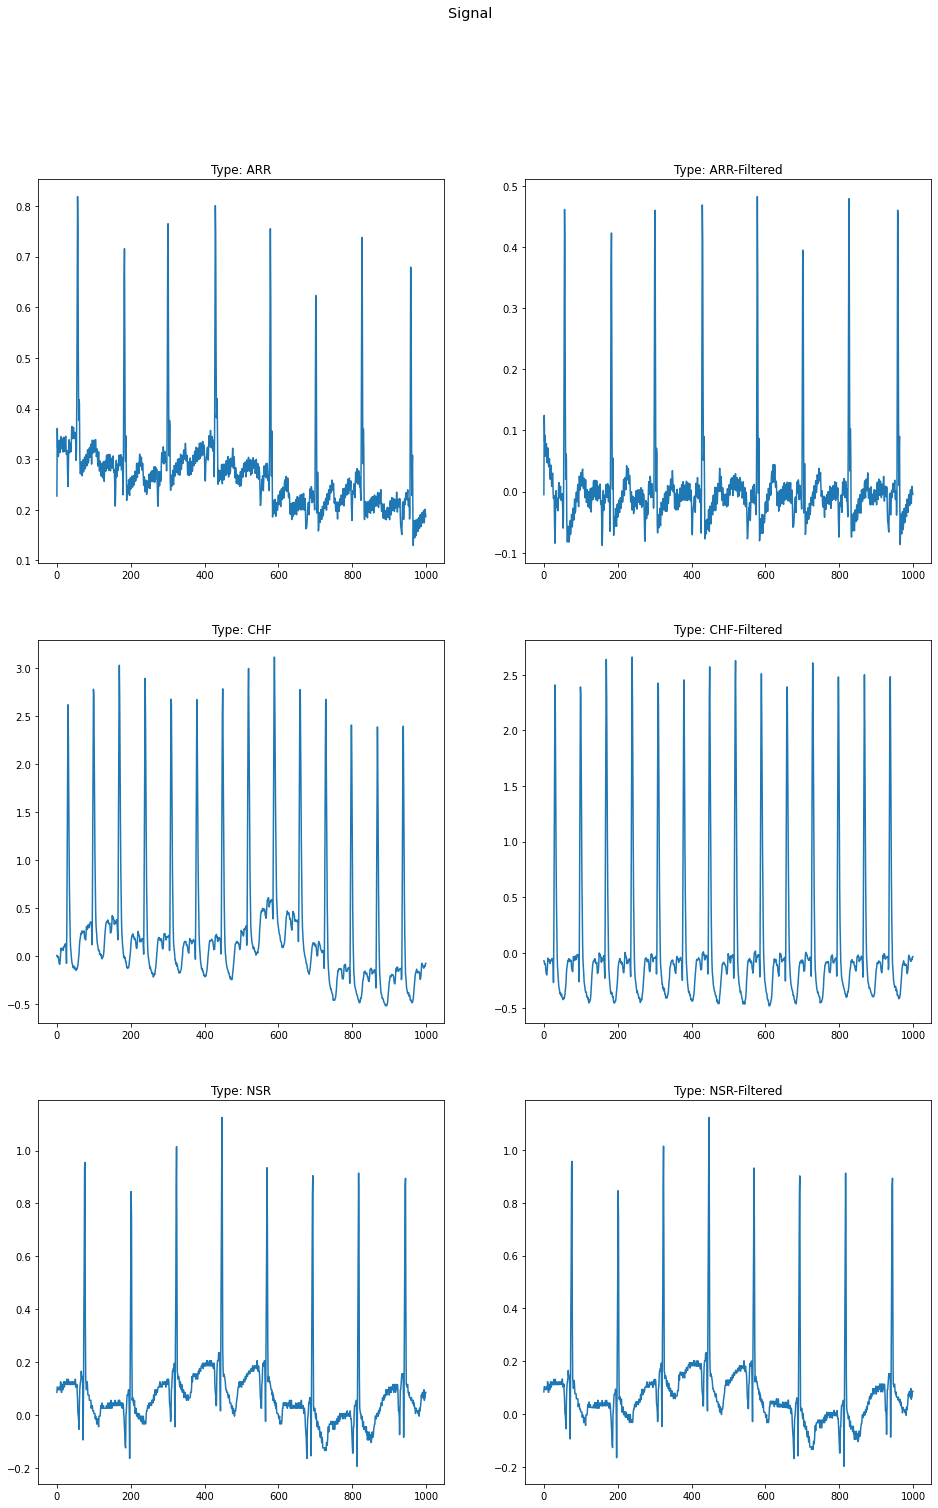

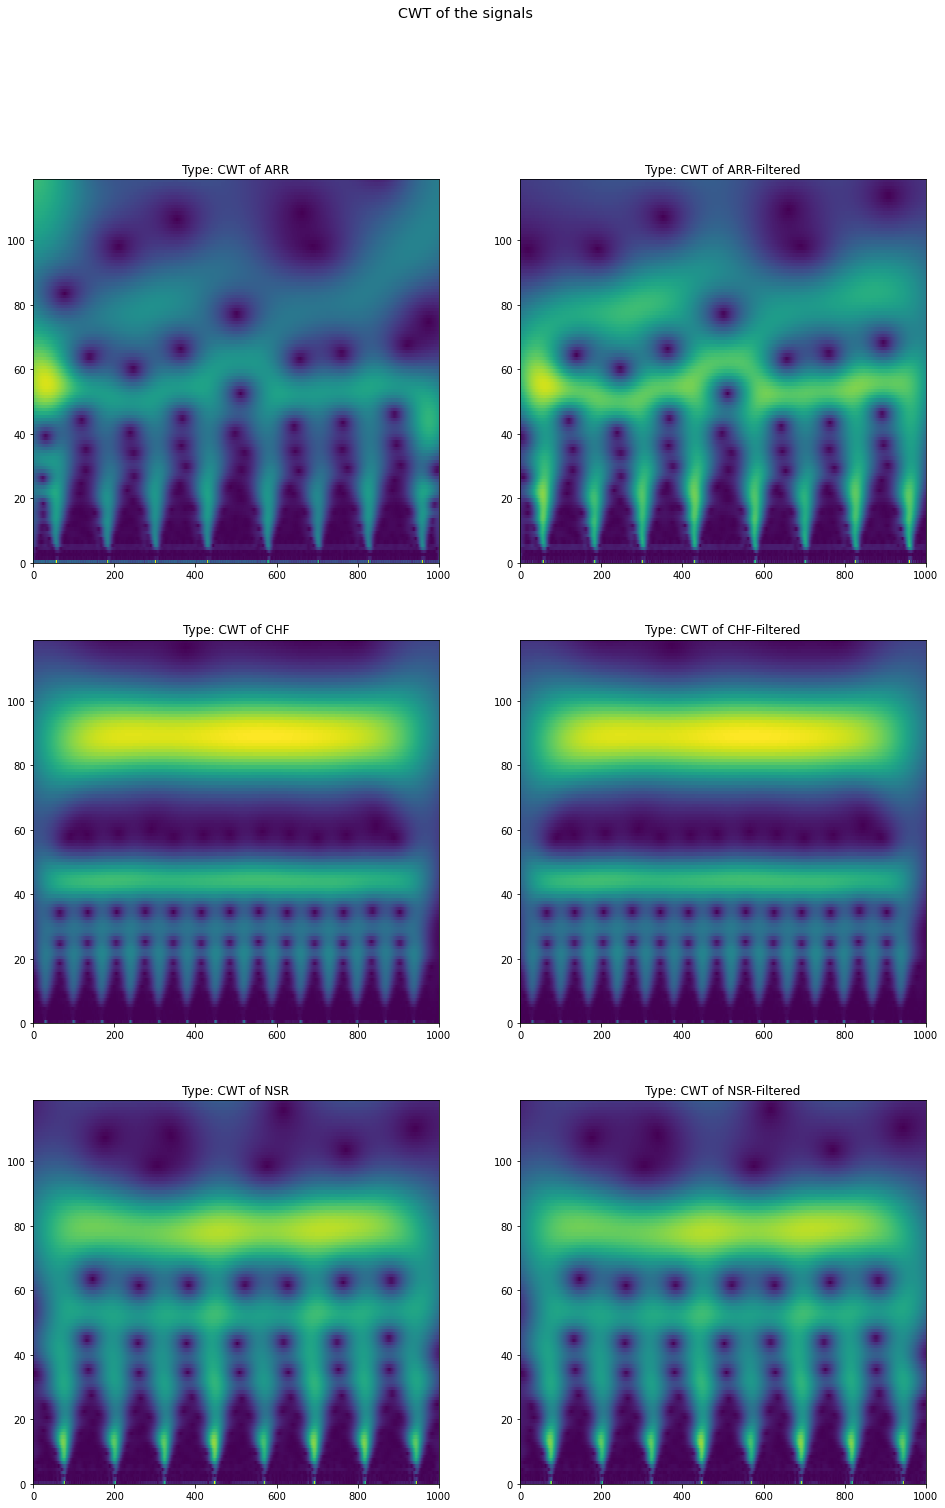

In [10]:
ind_ARR = np.random.randint(low = 0,high = sig_ARR.shape[0])
ind_CHF = np.random.randint(low = 0,high = sig_CHF.shape[0])
ind_NSR = np.random.randint(low = 0,high = sig_NSR.shape[0])

fig1 = plt.figure(1)
fig1, ax1 = plt.subplots(3,2)
fig1.suptitle("Signal", fontsize="x-large")
fig1.set_figheight(24)
fig1.set_figwidth(16)

fig2 = plt.figure(2)
fig2, ax2 = plt.subplots(3,2)
fig2.suptitle("CWT of the signals", fontsize="x-large")
fig2.set_figheight(24)
fig2.set_figwidth(16)

for i, ind in enumerate([ind_ARR, ind_CHF, ind_NSR]):
    if i ==0:
        sig = sig_ARR[ind]
        sigf = butter_highpass_filter(sig)
        sigf = notch_filter(sigf)
        lab = lab_ARR[ind]
    elif i ==1:
        sig = sig_CHF[ind]
        sigf = butter_highpass_filter(sig)
        sigf = notch_filter(sigf)
        lab = lab_CHF[ind]
    elif i ==2:
        sig = sig_NSR[ind]
        sigf = butter_highpass_filter(sig)
        sigf = notch_filter(sig)
        lab = lab_NSR[ind]       



    sig = sig[0:1000]
    sigf = sigf[0:1000]
    if(np.max(sig) < np.abs(np.min(sig)) ):
        sig = -1*sig
    if(np.max(sigf) < np.abs(np.min(sigf)) ):
        sigf = -1*sigf    
    cwt = signal.cwt(sig, signal.morlet2, widths=np.arange(1,120), w=8)
    cwtf = signal.cwt(sigf, signal.morlet2, widths=np.arange(1,120), w=8)
    

    ax1[i, 0].plot(sig)
    ax1[i, 0].set_title(f"Type: {lab}")
    ax1[i, 1].plot(sigf)
    ax1[i, 1].set_title(f"Type: {lab}-Filtered")

    ax2[i, 0].pcolormesh(np.abs(cwt))
    ax2[i, 0].set_title(f"Type: CWT of {lab}")
    ax2[i, 1].pcolormesh(np.abs(cwtf))
    ax2[i, 1].set_title(f"Type: CWT of {lab}-Filtered")

    print(f"Label: {lab}\tIndex: {ind}")

/tmp/ipykernel_66736/3469452370.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,4))


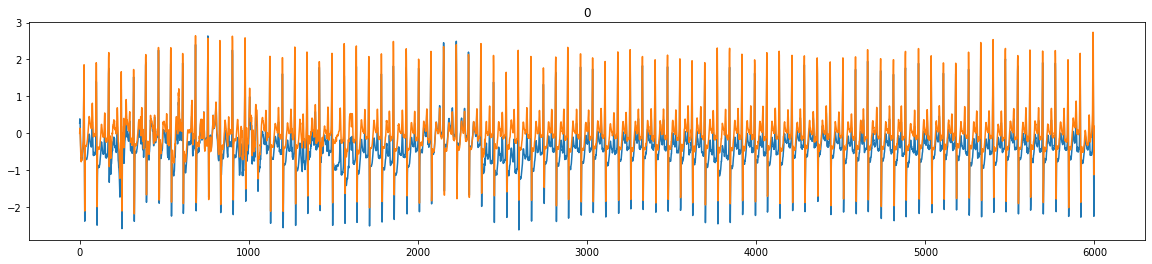

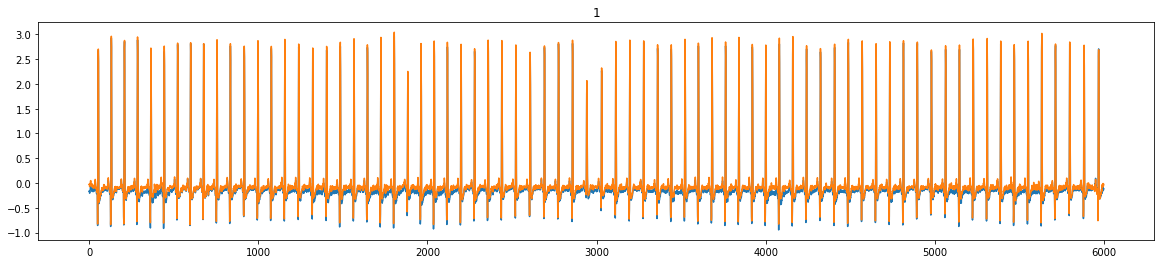

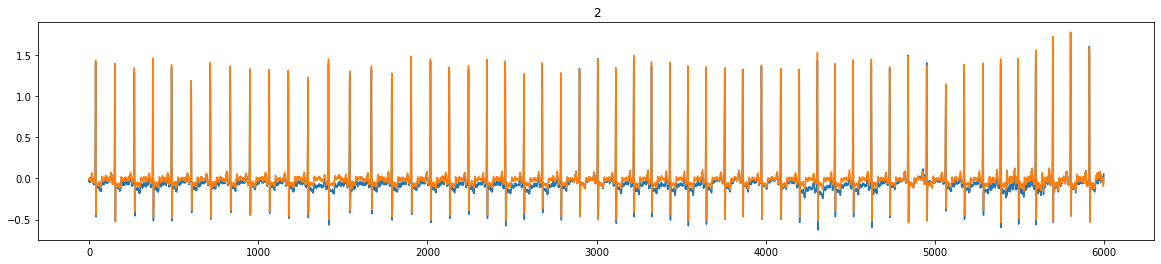

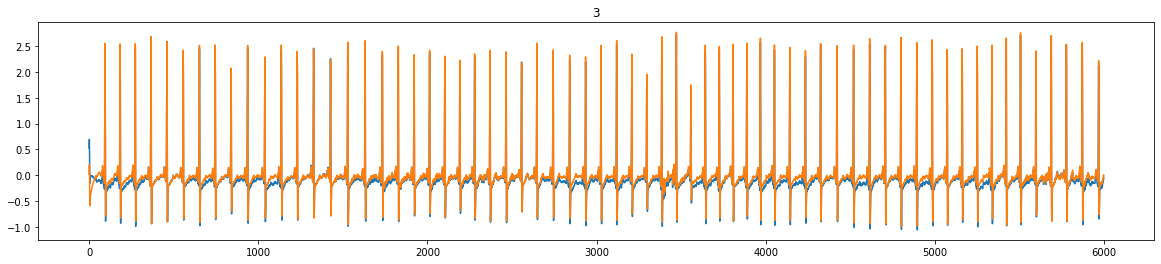

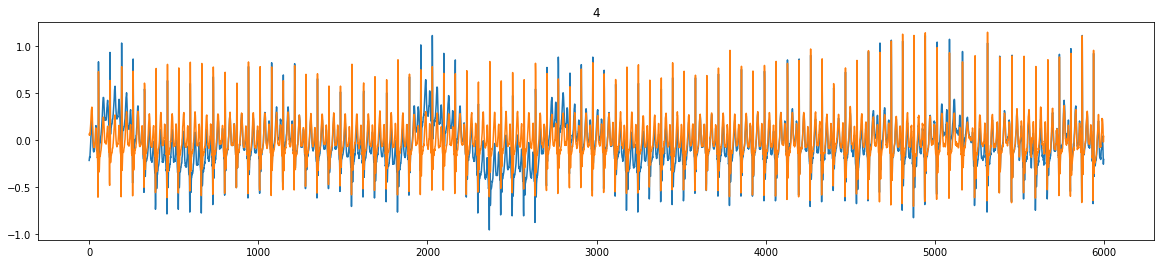

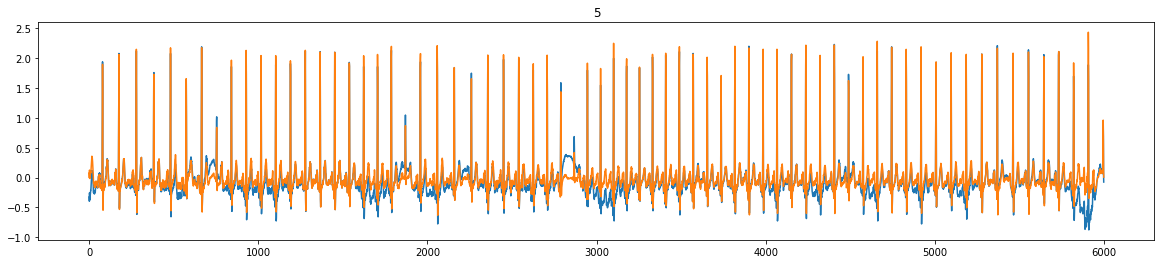

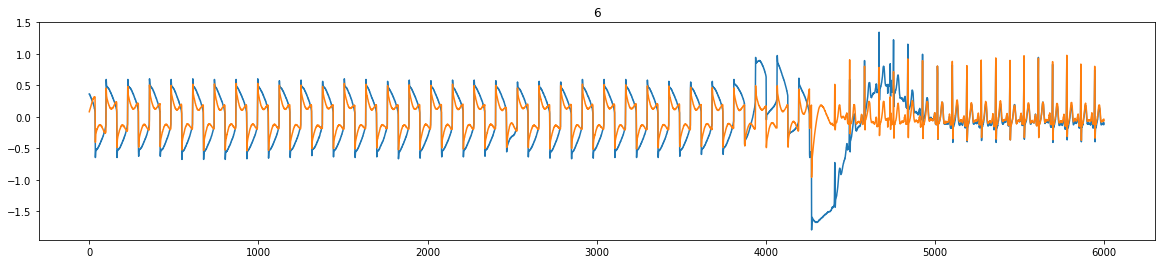

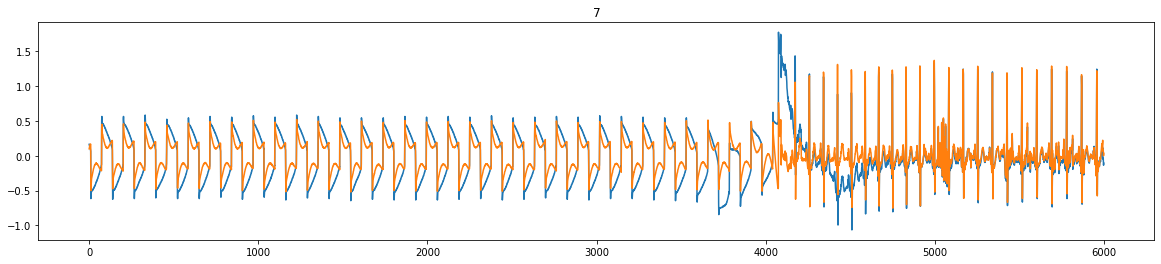

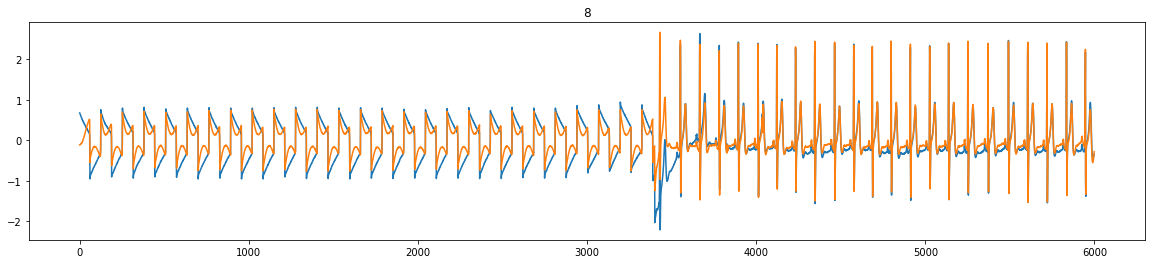

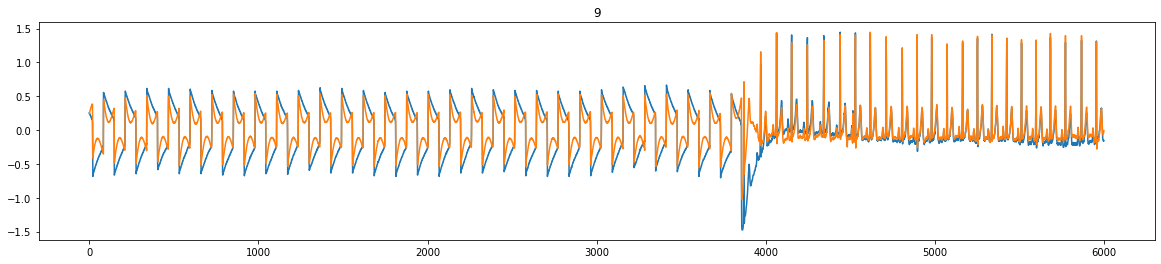

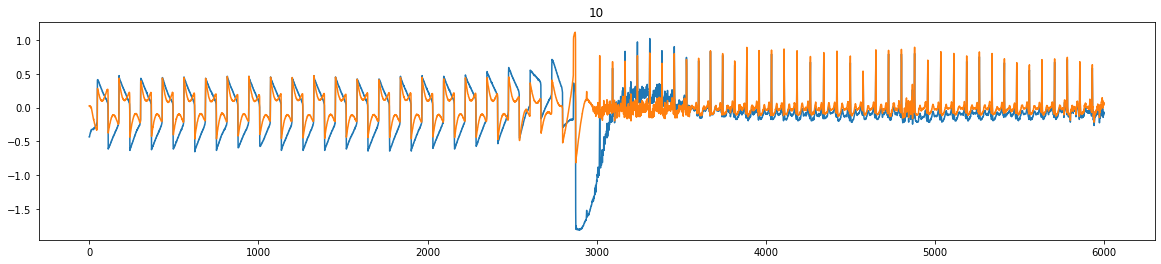

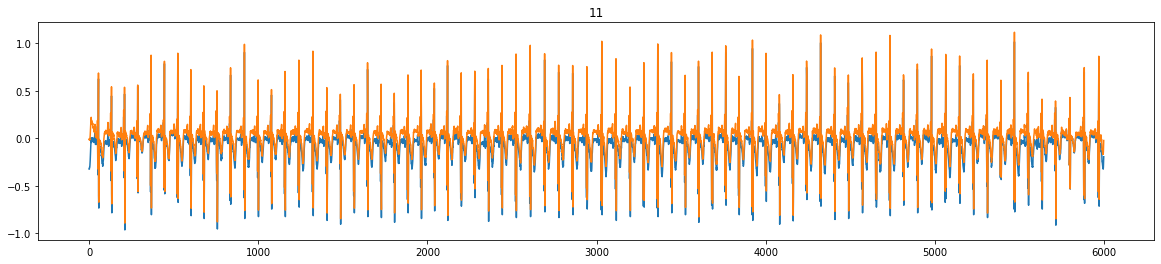

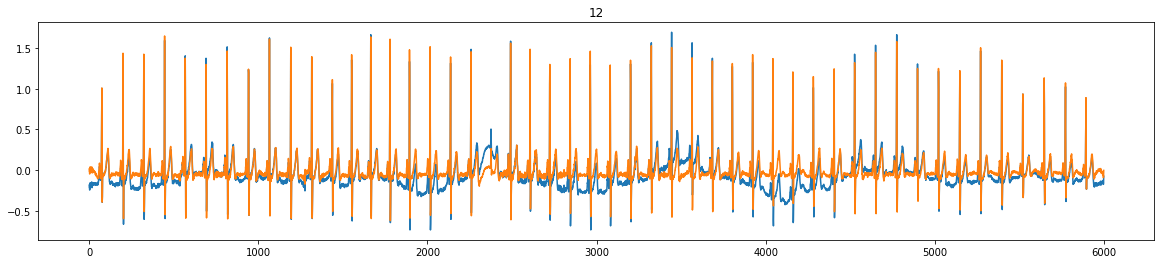

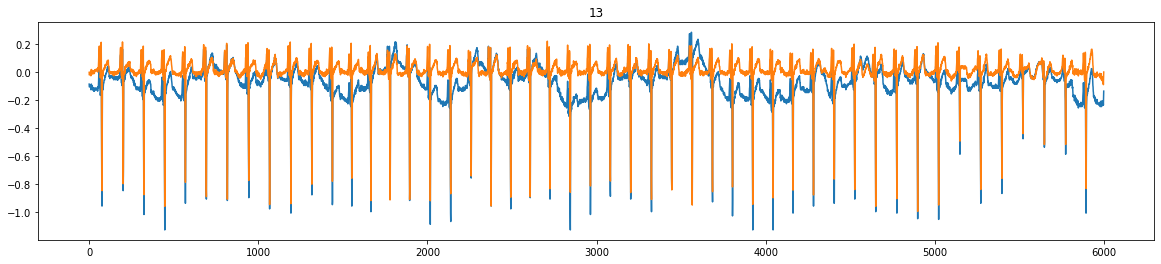

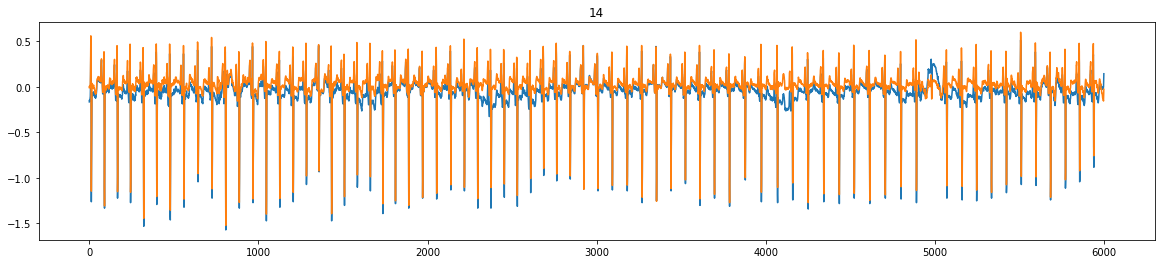

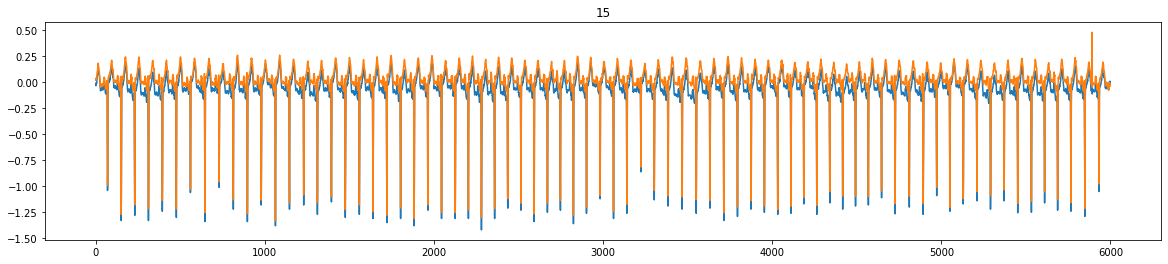

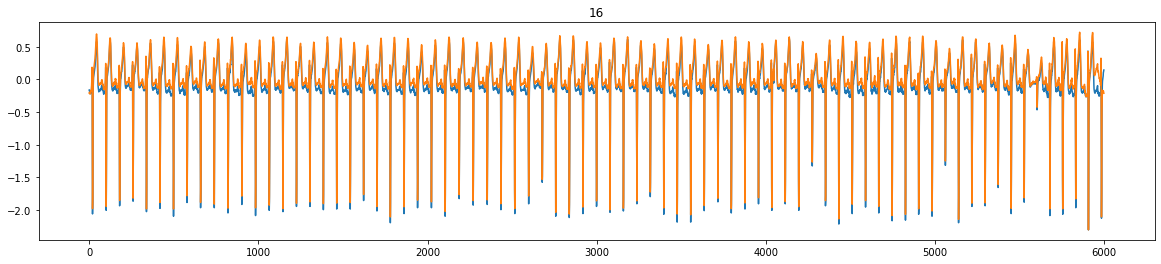

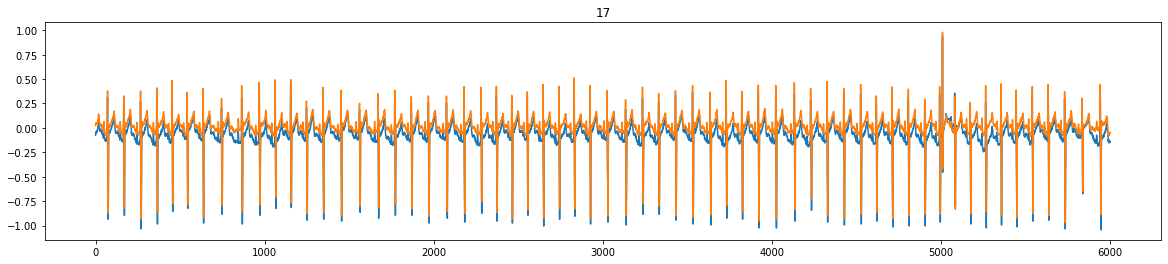

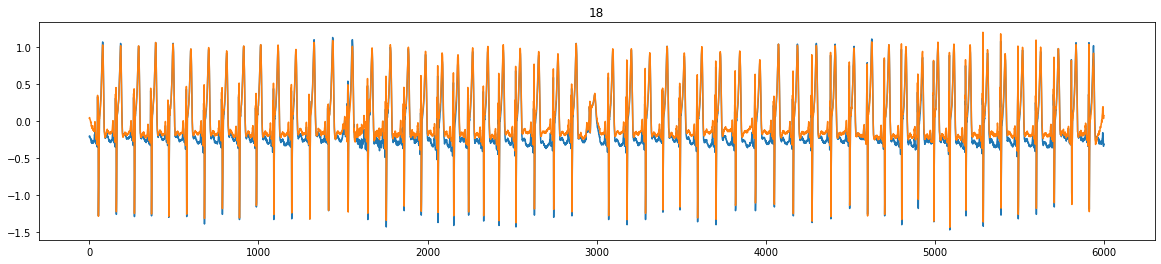

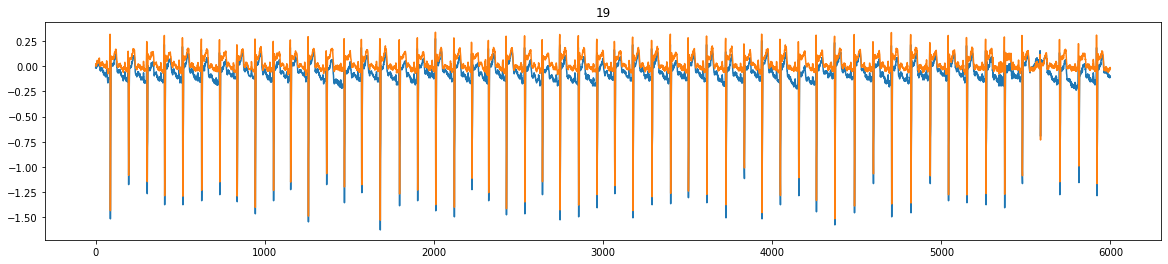

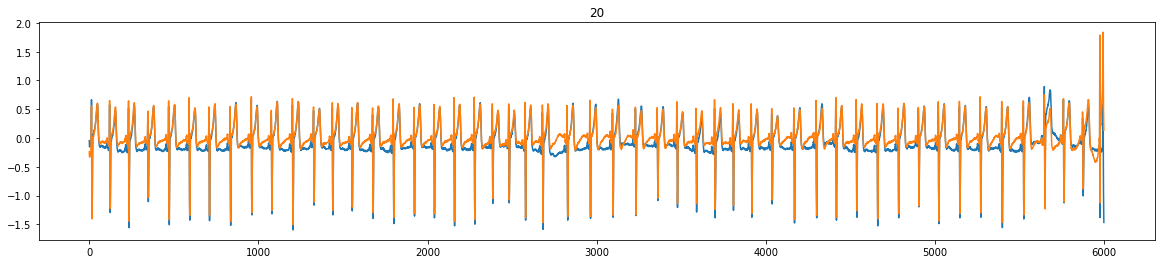

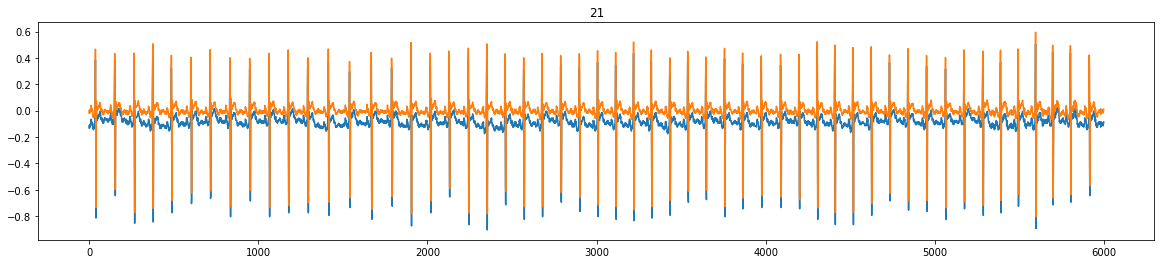

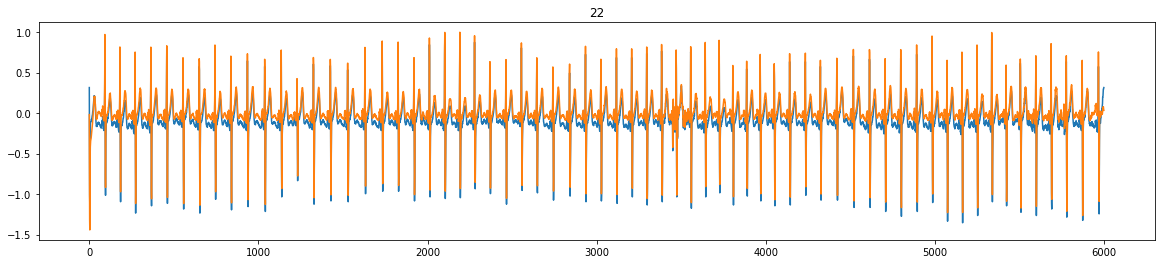

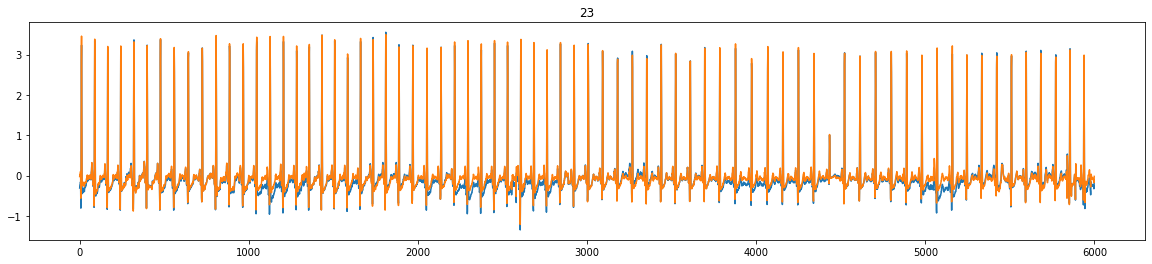

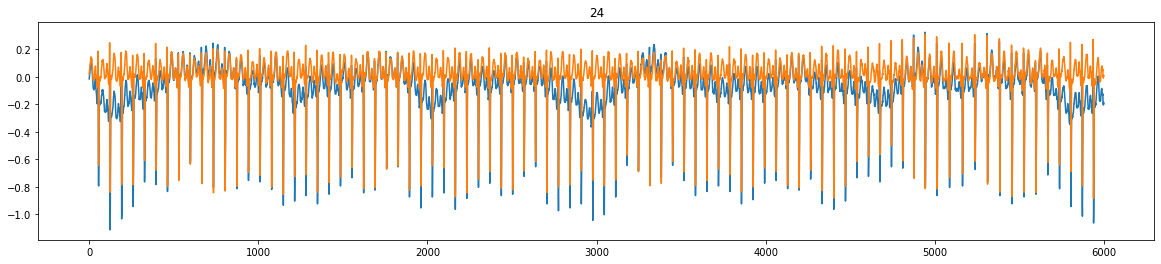

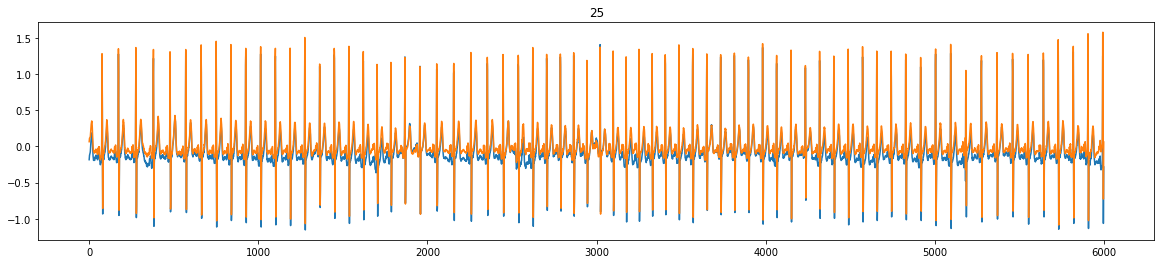

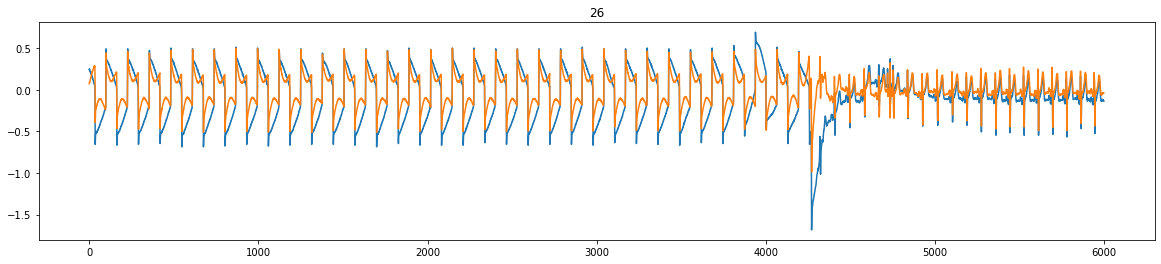

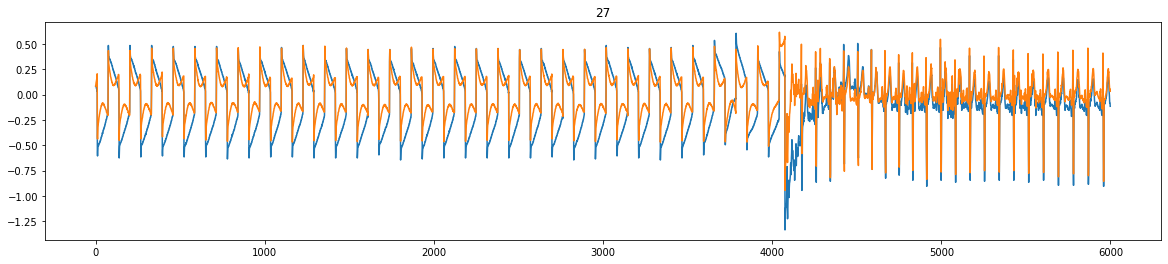

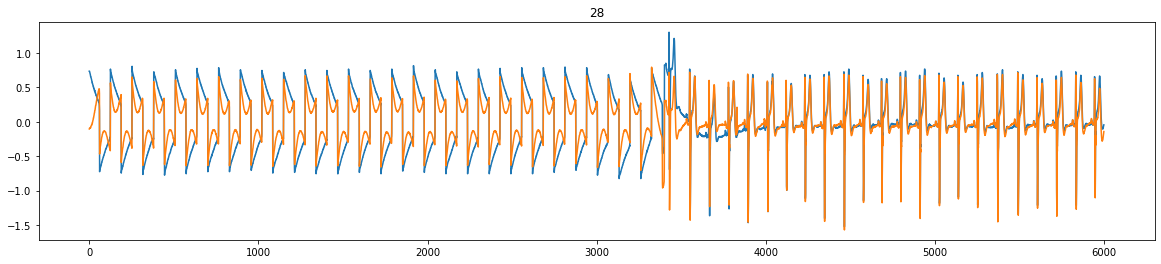

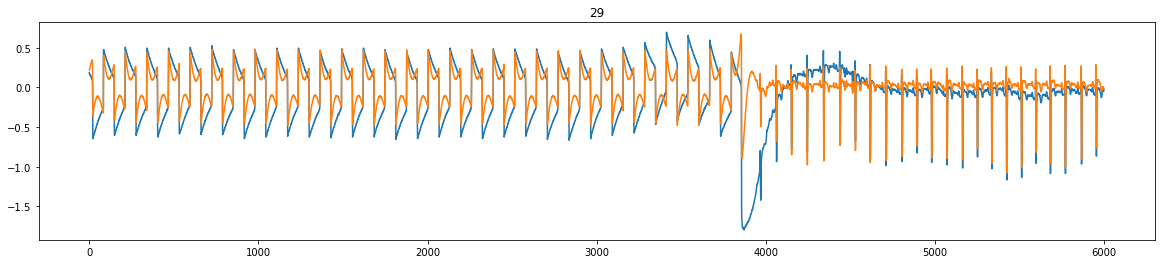

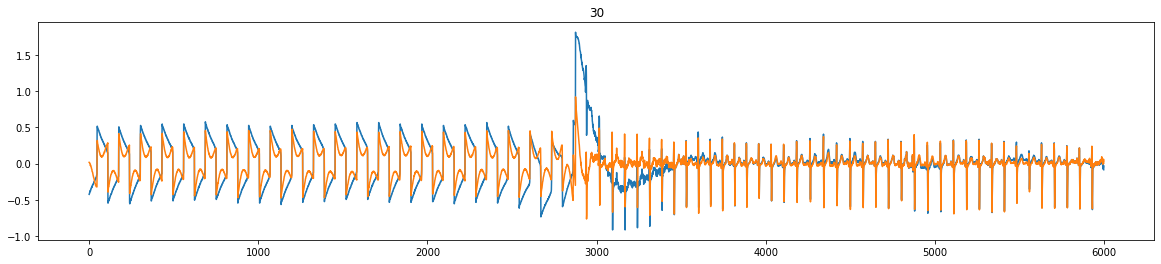

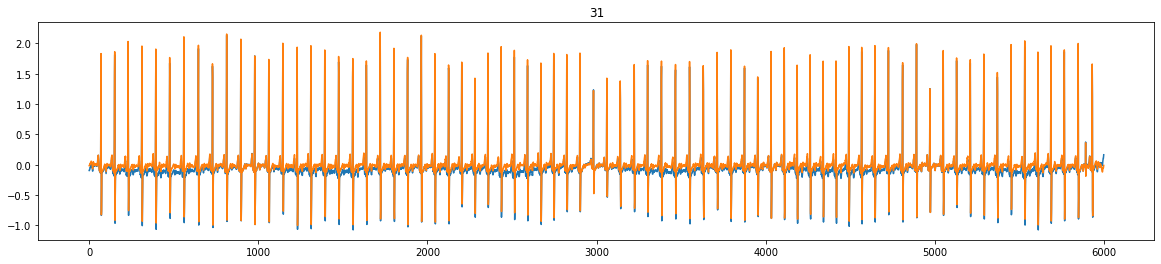

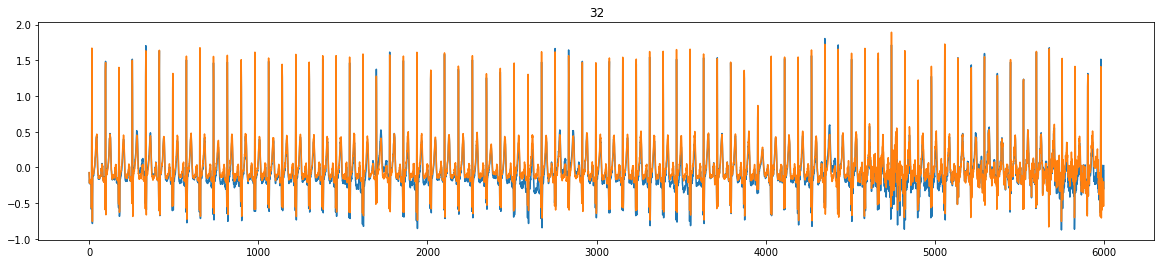

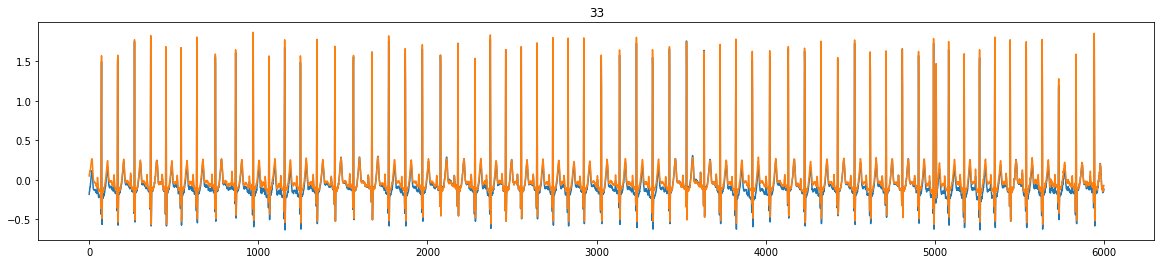

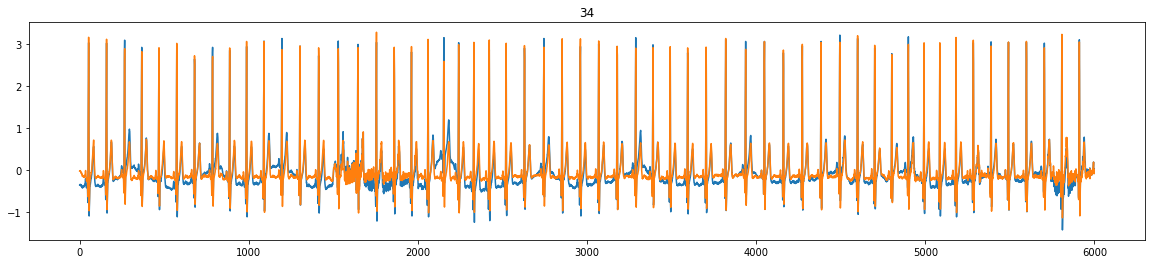

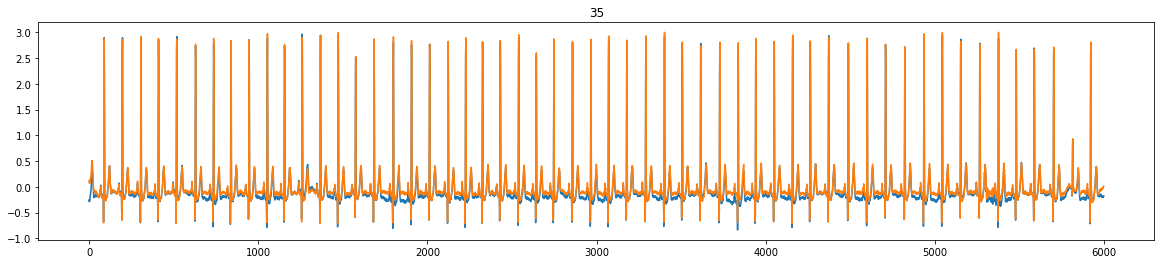

In [11]:
for i in range(0, sig_NSR.shape[0]):
    fig = plt.figure(figsize=(20,4))
    plt.plot(sig_NSR[i][0:6000])
    plt.title(i)
    plt.plot(notch_filter(butter_highpass_filter(sig_NSR[i][0:6000])))

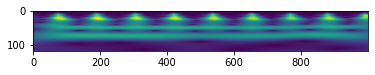

In [35]:
def process_signal(data):
    data = butter_highpass_filter(data)
    data = notch_filter(data)
    return data


def create_save_wavelets(data:np.ndarray, name:str):

    
    [os.makedirs(x, exist_ok=True) for x in ["Dataset/ARR", "Dataset/CHF", "Dataset/NSR"]]

    path = "Dataset/" + name.upper()

    if not os.path.isdir(path):
        assert NotADirectoryError(f"{path} is not a valid path")

    sig_len = data.shape[1]

    for i, sig in enumerate(data):

        imdir = path +"/"+ name+"_"+str(i)+".bmp"
        if(np.max(sig) < np.abs(np.min(sig)) ):
            sig = -1*sig
        sig = process_signal(sig)

        cwt = signal.cwt(sig[0:1000], signal.morlet2, widths=np.arange(1,120), w=8)
        cwt = np.abs(cwt)
        cwt = ((cwt - np.min(cwt)) * 255) / (np.max(cwt) - np.min(cwt))

        # print(np.max(cwt), np.min(cwt))
        plt.imshow(cwt)

        result = Image.fromarray(cwt)
        result = result.convert("RGB")
        result = result.resize((256,256), resample=Image.BICUBIC)
        result.save(imdir, format="bmp")

create_save_wavelets(sig_NSR, "NSR")        
create_save_wavelets(sig_ARR, "ARR")
create_save_wavelets(sig_CHF, "CHF")        
     